In [1]:
import collections
import sys
import subprocess
import pandas as pd
import os
import numpy as np
import uuid
import tempfile
import bnpy
import scikit_posthocs as sp
import itertools

from scipy.stats import kruskal, f_oneway

sys.path.append('/opt/hydra/')

src = os.environ["HYDRA_SRC"]

import library.analysis as hy

In [2]:
# This cmd was used to identify multimodal genes 
cmd = ["docker" ,
       "run",
       "-v", "$PWD:/data",
       "jpfeil/hydra@sha256:123bee0aa2b3e63084c773a13a16d247076462af910a104cd5776ba5e6d4b29d",
       "filter",
       "-e", "data/target-high-risk-nbl-mycn-na-exp-2018-11-12.tsv",
       "--output-dir", "output",
       "--CPU", "15"]

In [3]:
mm_genes = '../data/output/MultiModalGenes/'
exp_path = '../data/expression/target-high-risk-nbl-mycn-na-exp-2018-11-12.tsv'

In [4]:
exp = pd.read_csv(exp_path, sep='\t', index_col=0)

In [8]:
mms = []
for gene in os.listdir(mm_genes):
    mms.append(gene)

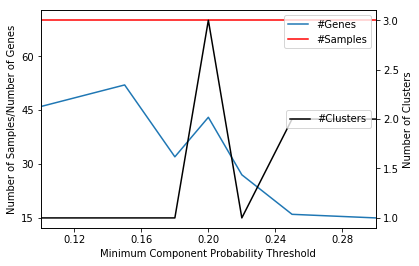

In [9]:
scan = hy.ScanEnrichmentAnalysis(mm_genes, 
                                 exp_path, 
                                 'GO', 
                                 min_prob_range=[0.1, 0.15, 0.18, 0.2, 0.22, 0.25, 0.3], 
                                 CPU=7,
                                 K=5).scan()

In [11]:
scan

,num_genesets,gs_terms,gs_term_genes,num_genes,num_clusters,num_samples
min_prob_filter,,,,,,
0.10,6,nuclear division|mitotic nuclear division|meio...,MKI67|IGHV4-4|MAD2L1|PIWIL2|BUB1B|PLK1|BIRC5|P...,46,1,70
0.15,4,adaptive immune response|mitotic nuclear divis...,IGHV4-4|CD1E|SYCE1|IGHV1-3|IGKV1-16|PKMYT1|MAD...,52,1,70
0.18,5,adaptive immune response|humoral immune respon...,IGHV4-4|CD1E|IGKV1-16|IGHV3-73|UCN3|CRH|IGKV1D...,32,1,70
0.20,4,adaptive immune response|mesenchyme developmen...,IGHV4-4|CD1E|IGKV1-16|TGFB2|IGHV3-73|UCN3|CRH|...,43,3,70
0.22,5,humoral immune response|immunoglobulin mediate...,IGHV4-4|IGKV1-16|IGHV3-73|UCN3|CRH|MS4A1|TAC1|...,27,1,70
0.25,1,humoral immune response,CR2|IGHV4-4|IGHV1-69|IGKV2D-28|FCER2|IGHV1-3|I...,16,2,70
0.30,1,humoral immune response,CR2|IGHV4-4|IGHV1-69|IGKV2D-28|FCER2|IGHV1-3|T...,15,2,70


In [12]:
res = hy.EnrichmentAnalysis(exp_path=exp_path,
                            mm_path=mm_genes,
                            min_prob_filter=0.2,
                            gmt_path='GO')

In [13]:
terms = res.get_enriched_terms()

In [14]:
genes = res.get_enriched_term_genes()

len(genes)

43

In [15]:
exp.reindex(genes).to_csv('../tmp/training-data.tsv', sep='\t')

In [16]:
clus = hy.MultivariateMixtureModel(data=exp.reindex(genes),
                                   center=True,
                                   gamma=5.0,
                                   variance=2.0,
                                   K=5, 
                                   verbose=True)

centering data


In [17]:
clus

In [18]:
bnpy.ioutil.ModelWriter.save_model(clus.hmodel,
                                   '../tmp/',
                                   prefix='EnrichmentAnalysisV1')

In [19]:
cfeat = clus.get_cluster_features(exp)

In [20]:
!ls

standardization.ipynb		     TARGET-neuroblastoma-analysis-TEST.ipynb
TARGET-neuroblastoma-analysis.ipynb


In [21]:
for c, d in cfeat.items():
    pth = '../tmp/cluster-features-%d.tsv' % c
    d.to_csv(pth, sep='\t')

In [22]:
len(cfeat)

3

In [23]:
cfeat[0].head(10)

,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
pathway,,,,,,,
B CELL RECEPTOR SIGNALING PATHWAY%GOBP%GO:0050853,0.000075,0.003629,0.839919,3.841648,0,46,CD79A|CD79B|IGHV1OR15-1|LCK|CD19|PTPRC|IGHV1-6...
"COMPLEMENT ACTIVATION, CLASSICAL PATHWAY%GOBP%GO:0006958",0.000080,0.003629,0.818695,3.334076,0,29,IGHV1OR15-1|IGHV1-69-2|IGHV5-51|IGHV1-18|IGHV3...
"PHAGOCYTOSIS, RECOGNITION%GOBP%GO:0006910",0.000080,0.003629,0.830335,3.288762,0,26,IGHV1OR15-1|IGHV1-69-2|IGHV5-51|IGHV1-18|IGHV3...
HALLMARK_E2F_TARGETS%MSIGDB_C2%HALLMARK_E2F_TARGETS,0.000067,0.003629,0.558753,3.236425,0,200,EZH2|CDKN3|LSM8|PSMC3IP|ASF1B|KIF18B|RPA2|BRCA...
POSITIVE REGULATION OF B CELL ACTIVATION%GOBP%GO:0050871,0.000073,0.003629,0.662490,3.202577,0,59,IGHV1OR15-1|CD27|FCRL3|SASH3|PTPRC|IGHV1-69-2|...
ANTIGEN RECEPTOR-MEDIATED SIGNALING PATHWAY%GOBP%GO:0050851,0.000069,0.003629,0.575481,3.184088,0,133,CD79A|CD79B|IGHV1OR15-1|LCK|GRAP2|CD3D|CD19|CD...
HUMORAL IMMUNE RESPONSE MEDIATED BY CIRCULATING IMMUNOGLOBULIN%GOBP%GO:0002455,0.000078,0.003629,0.759417,3.172643,0,32,IGHV1OR15-1|IGHV1-69-2|IGHV5-51|IGHV1-18|IGHV3...
ADAPTIVE IMMUNE RESPONSE%GOBP%GO:0002250,0.000070,0.003629,0.595926,3.154195,0,97,IGHV1OR15-1|SPN|CD27|SLAMF6|ZAP70|IGHV1-69-2|S...
T CELL ACTIVATION%GOBP%GO:0042110,0.000070,0.003629,0.593526,3.152445,0,99,LCK|SPN|CCL19|CD8B|CD3D|SLAMF6|CD3E|ZAP70|CD3G...


In [24]:
cfeat[1].head(10)

,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
pathway,,,,,,,
TRANSLATION%REACTOME%R-HSA-72766.3,0.000677,0.007749,0.480020,4.019997,0,289,MRPL24|EARS2|MRPL15|MRPL48|EPRS|EEF1E1|DAP3|SS...
TRANSLATION%GOBP%GO:0006412,0.000726,0.008204,0.465784,3.938826,0,309,MRPL24|EARS2|MRPL15|MRPL48|EPRS|EEF1E1|DAP3|NH...
PEPTIDE BIOSYNTHETIC PROCESS%GOBP%GO:0043043,0.000775,0.008552,0.436769,3.716930,0,327,MRPL24|EARS2|MRPL15|MRPL48|EPRS|EEF1E1|DAP3|NH...
MITOCHONDRIAL GENE EXPRESSION%GOBP%GO:0140053,0.000355,0.004723,0.511179,3.710753,0,134,MRPL24|EARS2|MRPL15|MRPL48|DAP3|MRPL1|DARS2|TF...
MITOCHONDRIAL TRANSLATION%GOBP%GO:0032543,0.000319,0.004377,0.532506,3.707219,0,111,MRPL24|EARS2|MRPL15|MRPL48|DAP3|MRPL1|DARS2|WA...
TRNA AMINOACYLATION%REACTOME DATABASE ID RELEASE 66%379724,0.000220,0.003326,0.676080,3.666344,0,42,EARS2|EPRS|EEF1E1|DARS|NARS2|LARS|DARS2|WARS2|...
TRNA AMINOACYLATION FOR PROTEIN TRANSLATION%GOBP%GO:0006418,0.000219,0.003326,0.666116,3.649672,0,43,EARS2|EPRS|EEF1E1|DARS|NARS2|LARS|DARS2|WARS2|...
AMINO ACID ACTIVATION%GOBP%GO:0043038,0.000223,0.003365,0.650627,3.618729,0,46,EARS2|EPRS|EEF1E1|DARS|NARS2|LARS|DARS2|WARS2|...
TRNA AMINOACYLATION%GOBP%GO:0043039,0.000223,0.003365,0.650627,3.618729,0,46,EARS2|EPRS|EEF1E1|DARS|NARS2|LARS|DARS2|WARS2|...


In [25]:
cfeat[2].head(10)

,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
pathway,,,,,,,
HALLMARK_TNFA_SIGNALING_VIA_NFKB%MSIGDB_C2%HALLMARK_TNFA_SIGNALING_VIA_NFKB,0.000490,0.004083,0.779975,6.683279,0,187,FOSL1|MAFF|KLF9|INHBA|NR4A2|BHLHE40|FOSL2|PER1...
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION%MSIGDB_C2%HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,0.000495,0.004091,0.739276,6.352393,0,189,INHBA|THBS1|TNFRSF12A|FOXC2|CTGF|GADD45B|THBS2...
EXTRACELLULAR MATRIX ORGANIZATION%REACTOME%R-HSA-1474244.2,0.000539,0.004263,0.636208,5.649398,0,221,COL8A1|THBS1|P3H2|ITGA11|COL12A1|MMP19|LAMA2|A...
EXTRACELLULAR STRUCTURE ORGANIZATION%GOBP%GO:0043062,0.000531,0.004214,0.623188,5.510328,0,214,COL8A1|THBS1|ITGA11|CREB3L1|COL12A1|MMP19|LAMA...
EXTRACELLULAR MATRIX ORGANIZATION%GOBP%GO:0030198,0.000495,0.004091,0.640333,5.488395,0,188,COL8A1|THBS1|ITGA11|CREB3L1|COL12A1|MMP19|LAMA...
HALLMARK_INFLAMMATORY_RESPONSE%MSIGDB_C2%HALLMARK_INFLAMMATORY_RESPONSE,0.000434,0.003774,0.652136,5.373283,0,156,INHBA|AXL|KLF6|IL6|OSMR|HBEGF|LIF|SCN1B|SERPIN...
HALLMARK_INTERFERON_GAMMA_RESPONSE%MSIGDB_C2%HALLMARK_INTERFERON_GAMMA_RESPONSE,0.000505,0.004136,0.619416,5.343191,0,194,LATS2|MT2A|PTGS2|IL6|SOCS3|IFITM3|CFH|ARID5B|T...
NABA_CORE_MATRISOME%MSIGDB_C2%NABA_CORE_MATRISOME,0.000514,0.004155,0.610122,5.270434,0,198,CRISPLD2|COL8A1|THBS1|CTGF|NOV|THBS2|COL12A1|M...
NABA_MATRISOME_ASSOCIATED%MSIGDB_C2%NABA_MATRISOME_ASSOCIATED,0.000988,0.006589,0.523431,5.140774,0,397,PLAT|ADAMTSL1|ANXA1|INHBA|P3H2|MMP19|IL6|TIMP3...


In [26]:
assignments = clus.get_assignments(exp.reindex(genes))

assign = pd.DataFrame(index=exp.columns,
                      columns=[1])

for sample, assignment in zip(exp.columns, assignments):
    assign.loc[sample, 1] = assignment + 1

In [27]:
assign.to_csv('../tmp/assignments.tsv', sep='\t', header=None)

In [28]:
hclust = hy.HClust(data=exp.reindex(genes))

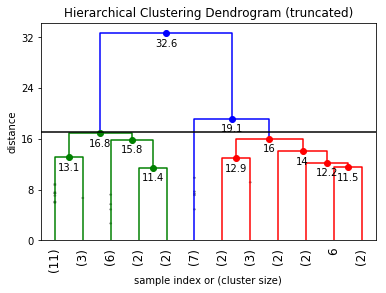

In [29]:
hclust.plot_row_linkage(17)
row_groups = hclust.get_row_groups(17)

In [30]:
!ls ../data/cluster-analysis

MYCN-NA-GAP-MAD-1000-labels-2.tsv
MYCN-NA-GAP-MAD-100-labels-6.tsv
MYCN-NA-GAP-MAD-2500-labels-2.tsv
MYCN-NA-GAP-MAD-5000-labels-1.tsv
MYCN-NA-GAP-MAD-500-labels-2.tsv
MYCN-NA-M3C-MAD-1000-labels-2.tsv
MYCN-NA-M3C-MAD-1000.tsv
MYCN-NA-M3C-MAD-100-labels-5.tsv
MYCN-NA-M3C-MAD-100.tsv
MYCN-NA-M3C-MAD-2500-labels-2.tsv
MYCN-NA-M3C-MAD-2500.tsv
MYCN-NA-M3C-MAD-5000-labels-2.tsv
MYCN-NA-M3C-MAD-5000.tsv
MYCN-NA-M3C-MAD-500-labels-3.tsv
MYCN-NA-M3C-MAD-500.tsv
MYCN-NA-M3C.tsv
NO-MM-MYCN-NA-GAP-MAD-1000-labels-2.tsv
NO-MM-MYCN-NA-GAP-MAD-100-labels-3.tsv
NO-MM-MYCN-NA-GAP-MAD-100-labels-6.tsv
NO-MM-MYCN-NA-GAP-MAD-2500-labels-2.tsv
NO-MM-MYCN-NA-GAP-MAD-5000-labels-1.tsv
NO-MM-MYCN-NA-GAP-MAD-500-labels-2.tsv
NO-MM-MYCN-NA-M3C-MAD-1000-labels-2.tsv
NO-MM-MYCN-NA-M3C-MAD-1000.tsv
NO-MM-MYCN-NA-M3C-MAD-100-labels-5.tsv
NO-MM-MYCN-NA-M3C-MAD-100-labels-8.tsv
NO-MM-MYCN-NA-M3C-MAD-100.tsv
NO-MM-MYCN-NA-M3C-MAD-2500-labels-2.tsv
NO-MM-MYCN-NA-M3C-MAD-2500.tsv
NO-MM-MYCN-NA-M3C-MAD-5000-labels-2.ts

In [31]:
pth = '../data/cluster-analysis/MYCN-NA-M3C-MAD-5000-labels-2.tsv'
m3c5000 = pd.read_csv(pth, sep='\t')
m3c5000.index = [x.replace('.', '-') for x in m3c5000.index.values]
m3c5000 = m3c5000.reindex(exp.columns)
m3c5000.head()

pth = '../data/cluster-analysis/MYCN-NA-M3C-MAD-500-labels-3.tsv'
m3c500 = pd.read_csv(pth, sep='\t')
m3c500.index = [x.replace('.', '-') for x in m3c500.index.values]
m3c500 = m3c500.reindex(exp.columns)
m3c500.head()

,consensuscluster
TARGET-30-PAITCI-01,2
TARGET-30-PAITEG-01,2
TARGET-30-PAIVHE-01,2
TARGET-30-PALBFW-01,2
TARGET-30-PALCBW-01,3


In [32]:
cmap = {0: 'r', 1:'b', 2:'g', 3:'y'}

col_colors = [cmap[i] for i in assignments]

m3c5000_colors = [cmap[i] for i in m3c5000['consensuscluster'].values]

m3c500_colors = [cmap[i] for i in m3c500['consensuscluster'].values]

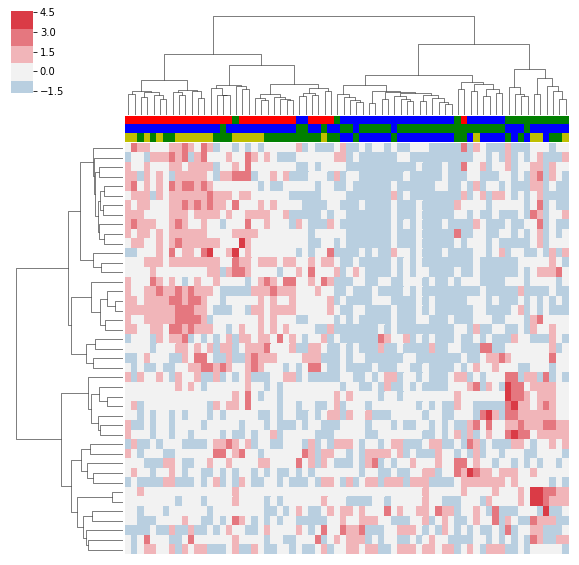

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

#col_order = assign.sort_values(1).index.values

g = sns.clustermap(exp.reindex(genes).dropna(),
                   z_score=0,
                   method='ward',
                   center=0,
                   col_colors=[col_colors, m3c5000_colors, m3c500_colors],
                   cmap=sns.diverging_palette(240, 10, n=7),
                   figsize=(10, 10))

ax = g.ax_heatmap

ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticklabels([])
ax.set_yticks([])

pth = '../img/NBL-expression-heatmap.svg'
plt.savefig(pth, format='svg', bbox_inches='tight')

In [34]:
# Add survival analysis

In [36]:
pth = '../data/meta/target-features-v2.tsv'

features = pd.read_csv(pth, sep='\t')

def feature_map(df, features):
    
    output = pd.DataFrame(columns=['cluster', 
                                   'sample', 
                                   'feature', 
                                   'value'])
    
    for cluster, rows in df.groupby(1):
        roots = ['-'.join(s.split('-')[:3]) for s in rows['index'].values]
        _f = features[features['root'].isin(roots)]
        for feature, value in _f.iterrows():
            output.loc[len(output), :] = [cluster, 
                                          value['root'], 
                                          value['feature'], 
                                          value['value']]
    return output

data = feature_map(assign.reset_index(),
                   features)

from collections import Counter

feature_clusters = pd.DataFrame(columns=['feature', 'value', 'cluster', 'fraction', 'count'])

for (feature, value), rows in data.groupby(['feature', 'value']):
    c = Counter(rows['cluster'].values)
    for cluster, count in c.items():
        frac = (count + 0.0) / sum(c.values())
        feature_clusters.loc[len(feature_clusters), :] = [feature, 
                                                          value, 
                                                          cluster, 
                                                          frac, 
                                                          count]
        
        
def _fisher(m):
    temp = os.path.join(tempfile.gettempdir(), 'M' + str(uuid.uuid4()))
    np.savetxt(temp, m, delimiter='\t')
    
    cmd = ['Rscript',
           os.path.join(src, 'bin', 'fisher.R'),
           temp]
    
    p = subprocess.Popen(cmd, stdout=subprocess.PIPE)
    
    stdout, stderr = p.communicate()
    
    return float(stdout)
        
def fisher(feature, value, df, background=None, mod=None):
    m = np.zeros((2, len(df['cluster'].unique())))
    
    for cluster, rows in df.groupby('cluster'):
        m1 = (rows['feature'] == feature) & (rows['value'] == value) & (rows['value'] != 'unknown') & (~pd.isnull(rows['value']))
        
        if background is None:
            m2 = (rows['feature'] == feature) & (rows['value'] != value) & (rows['value'] != 'unknown') & (~pd.isnull(rows['value']))
            
            #print rows[m2]
        
        else:
            m2 = (rows['feature'] == feature) & (rows['value'] == background) & (rows['value'] != 'unknown') & (~pd.isnull(rows['value']))
        
        n1 = rows[m1].shape[0]
        n2 = rows[m2].shape[0]
        
        # 1-indexed
        m[0, cluster - 1] += n1
        m[1, cluster - 1] += n2
        
    if m[0, :].sum() > m[1, :].sum():
        print("WARNING: Feature count is greater than background!")
    
    if mod is not None:
        for i, v in enumerate(mod):
            m[0, i] += v
        
    nr, nc = m.shape

    return _fisher(m), m


features.loc[features['feature'] == '%tumor', 'value'] = pd.to_numeric(features.loc[features['feature'] == '%tumor', 'value'])

features.loc[features['feature'] == 'age', 'value'] = pd.to_numeric(features.loc[features['feature'] == 'age', 'value'])

In [37]:
mf = pd.DataFrame(columns=['feature', 
                           'alteration', 
                           'p-value',
                           'cluster1',
                           'cluster2',
                           'cluster3',
                           #'cluster4',
                           'background1',
                           'background2',
                           'background3'])
                           #'background4'])

molecular_features = [('ATRX', 'deleted', None), 
                      ('ALK', 'mutated', None),
                      ('1q+', 'gain', None),
                      ('1p-', 'loss', None),
                      ('11q-', 'loss', None),
                      ('17q+', 'gain', None),
                      ('MKI', 'low', None),
                      ('MKI', 'intermediate', None),
                      ('MKI', 'high', None),
                      ('Grade', 'differentiating', None)]

for feature, alteration, background in molecular_features:
    print feature, alteration
    p, m = fisher(feature, alteration, data, background=background)
    print p
    print m
    
    mf.loc[len(mf), :] = [feature, alteration, p] + list(m.flatten())

mf.sort_values('p-value').to_csv('../data/meta/molecular-feature-table.tsv', 
                                 sep='\t',
                                 index=False)

ATRX deleted
0.0373085
[[ 7.  0.  0.]
 [22. 16.  9.]]
ALK mutated
0.5305588
[[ 2.  3.  1.]
 [27. 13. 12.]]
1q+ gain
0.169861
[[ 4.  6.  2.]
 [25. 10. 11.]]
1p- loss
0.05707522
[[ 1.  4.  2.]
 [28. 12. 11.]]
11q- loss
0.3168828
[[23.  9. 10.]
 [ 6.  7.  3.]]
17q+ gain
0.006128815
[[29. 12. 10.]
 [ 0.  4.  3.]]
MKI low
0.008846356
[[ 4.  9.  6.]
 [22.  9.  4.]]
MKI intermediate
0.1768113
[[15.  6.  3.]
 [11. 12.  7.]]
MKI high
0.4997228
[[ 7.  3.  1.]
 [19. 15.  9.]]
Grade differentiating
0.01142585
[[ 0.  3.  3.]
 [27. 17.  7.]]


In [38]:
pth = '../data/immune/CIBERSORT.Output_Job17-target-mycn-na.txt'
ciber = pd.read_csv(pth, index_col=0, sep='\t')

pth = '../data/immune/mycn-na-target-estimate.tsv'
est = pd.read_csv(pth, sep='\t', comment='#', header=1, index_col=0)
est.drop('Description', axis=1, inplace=True)
est.columns = [x.replace('.', '-') for x in est.columns]

pth = '../data/immune/xCell_target-high-risk-nbl-mycn-na-exp-2018-11-12_xCell_1754032119.txt'
xcell = pd.read_csv(pth, sep='\t', index_col=0)
xcell.columns = [x.replace('.', '-') for x in xcell.columns]

In [39]:
immune_groups = dict((group, []) for group in assign[1].unique())
immune = pd.DataFrame(columns=['sample', 'cluster', 'source', 'feature', 'value'])
for sample in assign.index.values:
    if sample not in ciber.index.values:
        print 'Misisng: ', sample
        continue
        
    assignment = assign.loc[sample, 1]
    
    immune_groups[assignment].append(sample)
    
    for score in ['StromalScore', 'ImmuneScore', 'ESTIMATEScore']:
        _est = est.loc[score, sample].item()
        immune.loc[len(immune), :] = [sample, assignment, 'Estimate', score, _est]
        
    immune.loc[len(immune), :] = [sample, assignment, 
                                'Estimate', 'TumorPurity', 
                                np.cos(0.6049872018 + 0.0001467884 * _est)]
    
    pvalue = ciber.loc[sample, 'P-value'].item()
    for cell, value in ciber.loc[sample, :].iteritems():
        immune.loc[len(immune), :] = [sample, assignment, 'CIBERSORT', cell, value]
        
    for cell, value in xcell[sample].iteritems():
        immune.loc[len(immune), :] = [sample, assignment, 'xCell', cell, value]

skip = ['P-value', 'Pearson Correlation', 'RMSE']        
immune = immune[~immune['feature'].isin(skip)]        
immune['value'] = pd.to_numeric(immune['value'])

In [40]:
sigs = collections.defaultdict(list)

p_values = pd.DataFrame(columns=['source', 
                                 'feature', 
                                 'A', 
                                 'B', 
                                 'holm p-value'])

for source, rows in immune.groupby('source'):
    print source
    nfeatures = len(rows['feature'].unique())
    alpha = 1 - (1 - 0.05) ** (1.0 / nfeatures)
    for feature in rows['feature'].unique():
        print(feature)
        groups3 = []
        for i, rows in immune[immune['feature'] == feature].groupby('cluster'):
            groups3.append(list(rows['value'].values))
            print i, rows['value'].mean()
    
        try:
            stat, pvalue = kruskal(*groups3)
            print(feature, pvalue, pvalue < alpha)
        
        except Exception as e:
            print e
            continue
    
        if pvalue < alpha:
            sigs[source].append(feature)
            
            try:
                res = sp.posthoc_mannwhitney(groups3, 
                                             p_adjust='holm')
                
            except Exception as e:
                print e
                continue
            
            for i, j in itertools.combinations(range(len(groups3)),
                                               2):
                
                if i == j:
                    continue 
                    
                p_values.loc[len(p_values), :] = [source,
                                                  feature,
                                                  i, 
                                                  j,
                                                  res.iloc[i, j]]

CIBERSORT
B cells naive
1 0.10499854775854042
2 0.019752905308562888
3 0.03350684030316408
('B cells naive', 5.102947661473475e-05, True)
B cells memory
1 0.0512232277502172
2 0.05150987321882916
3 0.02463152298310199
('B cells memory', 0.2099743280584646, False)
Plasma cells
1 0.05482474108434639
2 0.05602923516146801
3 0.05253436938309364
('Plasma cells', 0.5065261161600244, False)
T cells CD8
1 0.13560369395583224
2 0.03729920021885045
3 0.07402657423163263
('T cells CD8', 2.6199780806029447e-06, True)
T cells CD4 naive
1 0.0353262742976005
2 0.036899329756342865
3 0.010660596845789773
('T cells CD4 naive', 0.13572331415641828, False)
T cells CD4 memory resting
1 0.020440811117374433
2 0.08483298772661249
3 0.05669871397485885
('T cells CD4 memory resting', 0.03503518276271658, False)
T cells CD4 memory activated
1 0.00223097826533371
2 0.011429036071284506
3 0.02783823518395578
('T cells CD4 memory activated', 0.12049190601957332, False)
T cells follicular helper
1 0.08259781559497

3 0.07494615384615386
('NKT', 0.01665705400069958, False)
Neurons
1 0.014070967741935482
2 0.017769230769230766
3 0.012692307692307695
('Neurons', 0.2731027827993711, False)
Neutrophils
1 0.00039999999999999996
2 0.00041153846153846156
3 0.0015195841571801687
('Neutrophils', 0.5366579090371035, False)
Osteoblast
1 0.011483870967741937
2 0.02346153846153846
3 0.006300000000000001
('Osteoblast', 0.07038247302196027, False)
Pericytes
1 0.0033741935483870967
2 0.015423076923076925
3 0.02605384615384615
('Pericytes', 0.00798980571037754, False)
Plasma cells
1 0.05482474108434639
2 0.05602923516146801
3 0.05253436938309364
('Plasma cells', 0.5065261161600244, False)
Platelets
1 0.0024193548387096775
2 0.0016961538461538461
3 0.001
('Platelets', 0.10044550676512742, False)
Preadipocytes
1 0.013774193548387098
2 0.021992307692307693
3 0.040923076923076916
('Preadipocytes', 0.1886504001077148, False)
Sebocytes
1 0.005980645161290322
2 0.003234615384615385
3 0.0052307692307692315
('Sebocytes', 0

In [41]:
sigs

defaultdict(list,
            {'CIBERSORT': ['B cells naive',
              'T cells CD8',
              'T cells regulatory (Tregs)',
              'Monocytes',
              'Macrophages M1',
              'Eosinophils'],
             'Estimate': ['StromalScore',
              'ImmuneScore',
              'ESTIMATEScore',
              'TumorPurity'],
             'xCell': ['B-cells',
              'CD8+ Tcm',
              'CD8+ naive T-cells',
              'Chondrocytes',
              'Class-switched memory B-cells',
              'DC',
              'Eosinophils',
              'Epithelial cells',
              'Fibroblasts',
              'MSC',
              'Memory B-cells',
              'Mesangial cells',
              'Monocytes',
              'Smooth muscle',
              'aDC',
              'cDC',
              'naive B-cells',
              'pro B-cells',
              'ImmuneScore',
              'StromaScore',
              'MicroenvironmentScore']})

0 B cells naive
1 T cells CD8
2 T cells regulatory (Tregs)
3 Monocytes
4 Macrophages M1
5 Eosinophils


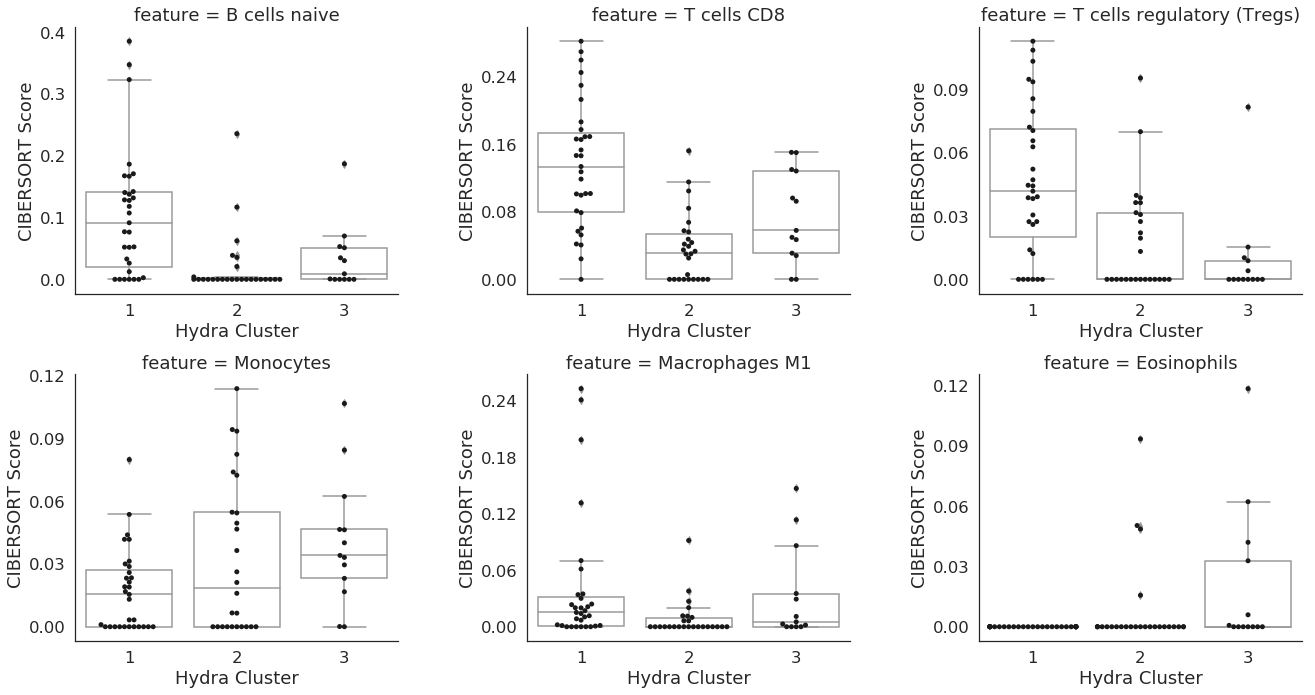

In [42]:
sns.set(font_scale=1.5, style='white')

mask = (immune['source'] == 'CIBERSORT') & (immune['feature'].isin(sigs['CIBERSORT']))

t = immune[mask]

g = sns.catplot(x='cluster', 
                y='value', 
                col='feature',
                kind='box',
                col_wrap=3,
                color='white',
                sharex=False,
                sharey=False,
                data=t,
                aspect=1.25)

for i, feature in enumerate(t['feature'].unique()):
    print i, feature
    sns.swarmplot(x='cluster',
                  y='value',
                  color='k',
                  size=5,
                  data=t[t['feature'] == feature],
                  ax=g.axes[i])

for i in range(len(g.axes)):
    g.axes[i].set_xlabel('Hydra Cluster')
    g.axes[i].set_ylabel('CIBERSORT Score')
    
plt.subplots_adjust(hspace=0.3, wspace=0.4)

pth = '../img/CIBERSORT-Plots.svg'
plt.savefig(pth, format='svg', bbox_inches='tight')

pth = '../img/CIBERSORT-Plots.png'
plt.savefig(pth, format='png', bbox_inches='tight')

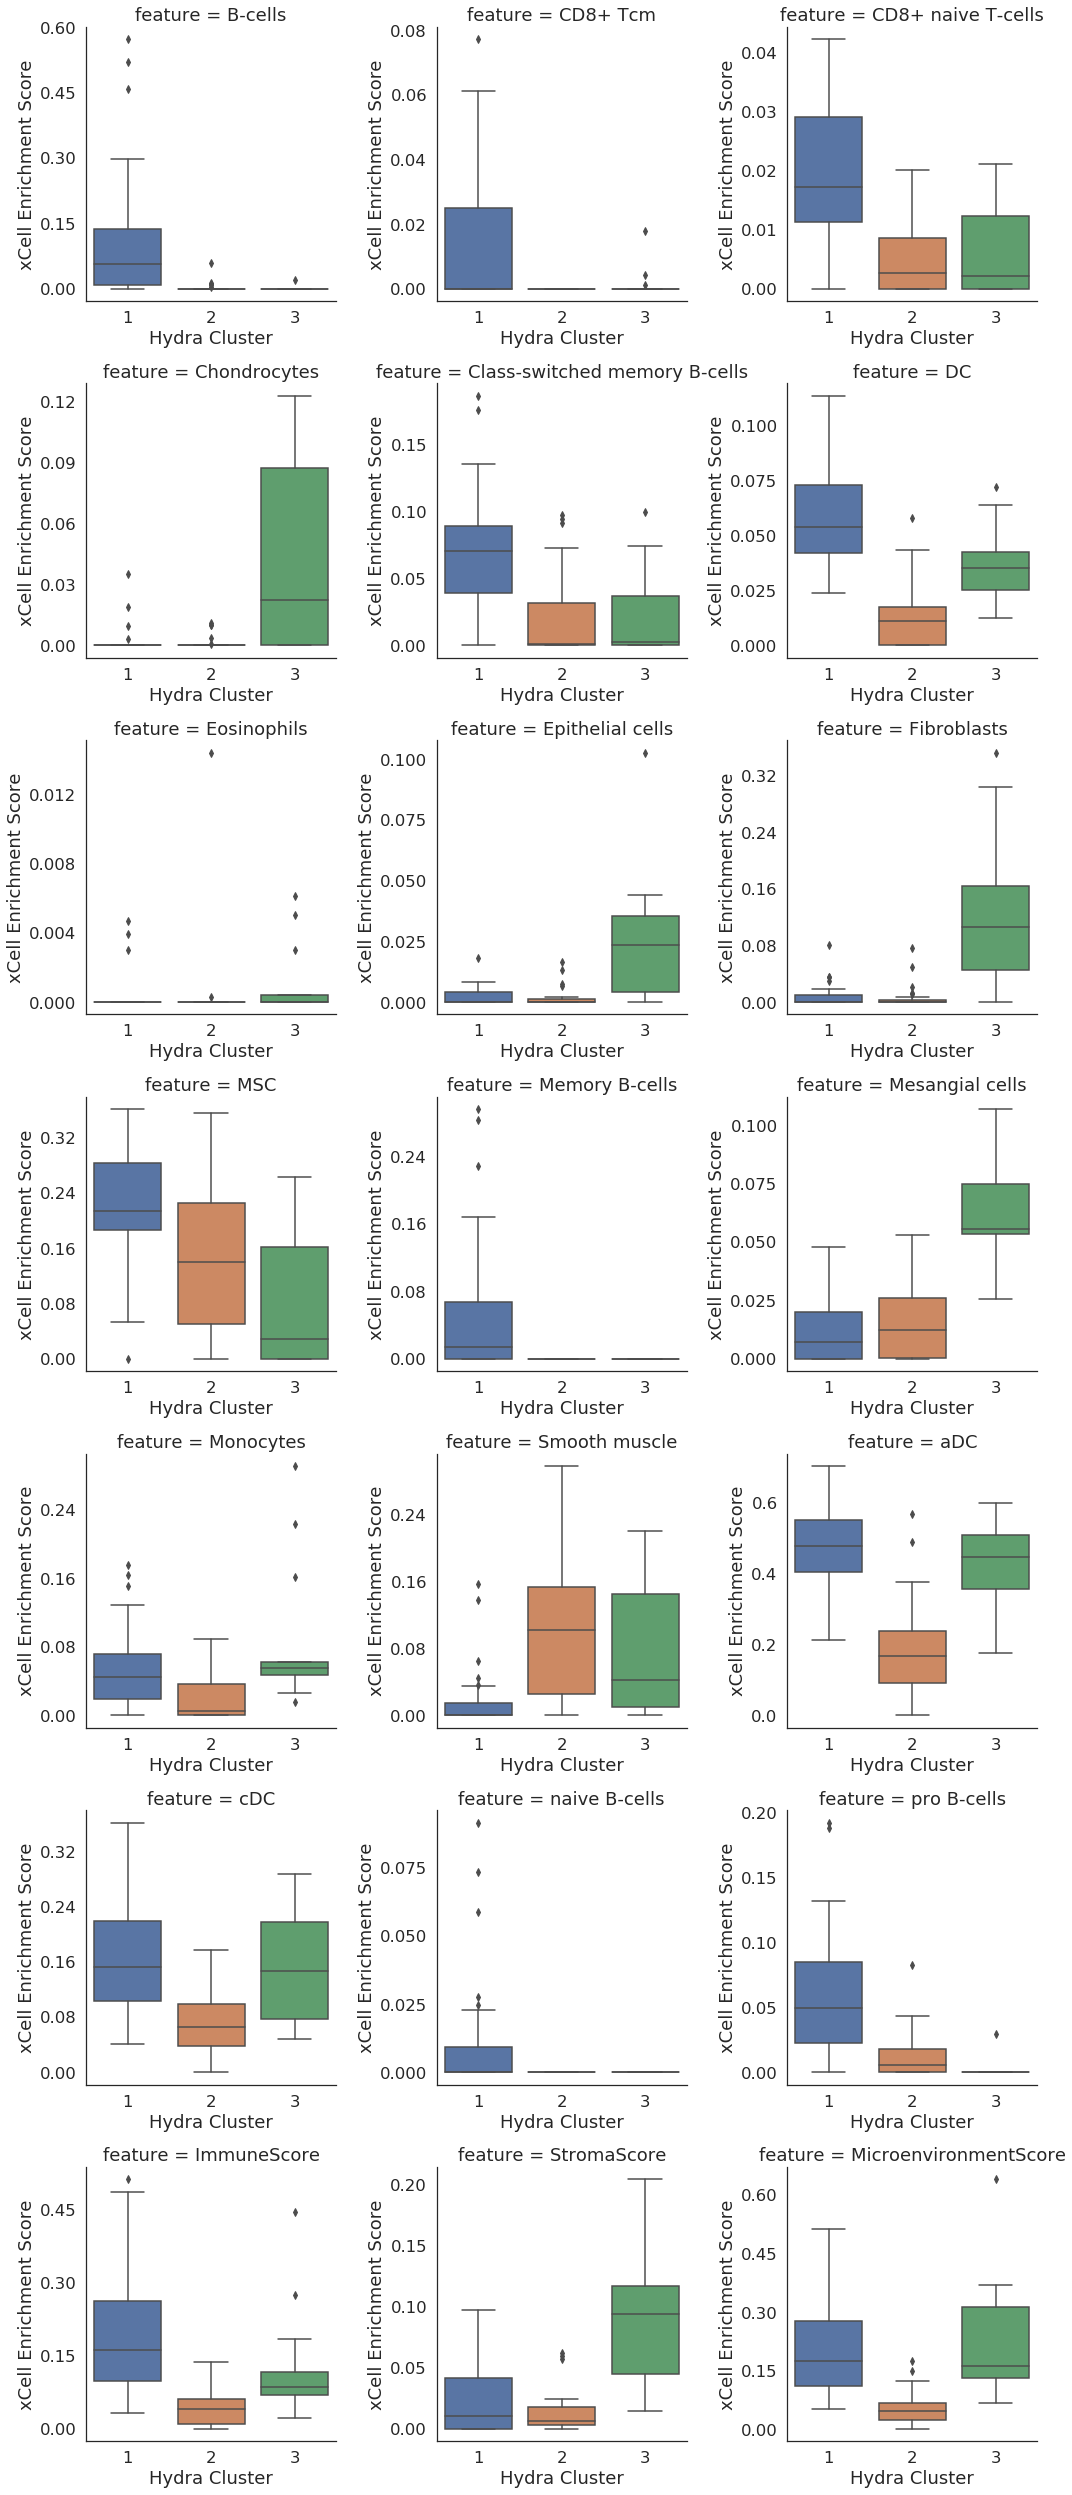

In [43]:
mask = (immune['source'] == 'xCell') & (immune['feature'].isin(sigs['xCell']))

t = immune[mask]

g = sns.catplot(x='cluster', 
                y='value', 
                col='feature',
                kind='box',
                col_wrap=3,
                sharex=False,
                sharey=False,
                data=t)

for i in range(len(g.axes)):
    g.axes[i].set_xlabel('Hydra Cluster')
    g.axes[i].set_ylabel('xCell Enrichment Score')
    
plt.subplots_adjust(hspace=0.3, wspace=0.4)

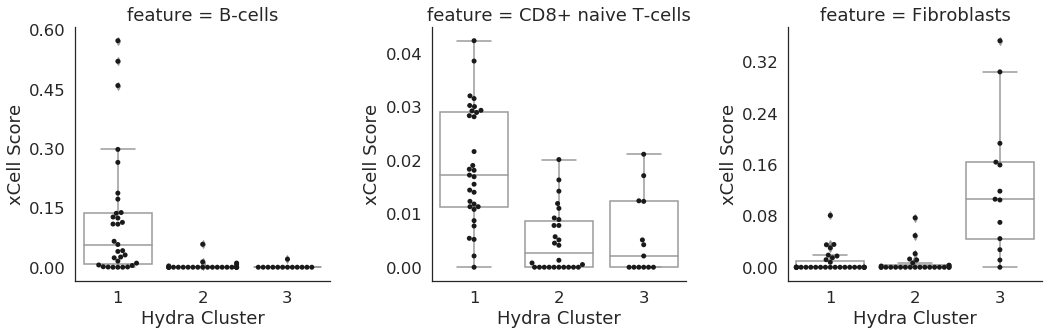

In [44]:
sns.set(font_scale=1.5, style='white')

interest = ["B-cells",
            "CD8+ naive T-cells",
            "Fibroblasts"]

mask = (immune['source'] == 'xCell') & (immune['feature'].isin(interest))

t = immune[mask]

g = sns.catplot(x='cluster', 
                y='value', 
                col='feature',
                kind='box',
                col_wrap=3,
                col_order=interest,
                color='white',
                sharex=False,
                sharey=False,
                data=t)

# CD8+
sns.swarmplot(x='cluster',
              y='value',
              color='k',
              size=5,
              data=t[t['feature'] == 'B-cells'],
              ax=g.axes[0])

# CD8+
sns.swarmplot(x='cluster',
              y='value',
              color='k',
              size=5,
              data=t[t['feature'] == 'CD8+ naive T-cells'],
              ax=g.axes[1])

# Fibroblasts
sns.swarmplot(x='cluster',
              y='value',
              color='k',
              size=5,
              data=t[t['feature'] == 'Fibroblasts'],
              ax=g.axes[2])

for i in range(len(g.axes)):
    g.axes[i].set_xlabel('Hydra Cluster')
    g.axes[i].set_ylabel('xCell Score')
    
plt.subplots_adjust(hspace=0.3, wspace=0.4)

pth = '../img/xCell-Plots.svg'
plt.savefig(pth, format='svg', bbox_inches='tight')

pth = '../img/xCell-Plots.png'
plt.savefig(pth, format='png', bbox_inches='tight')

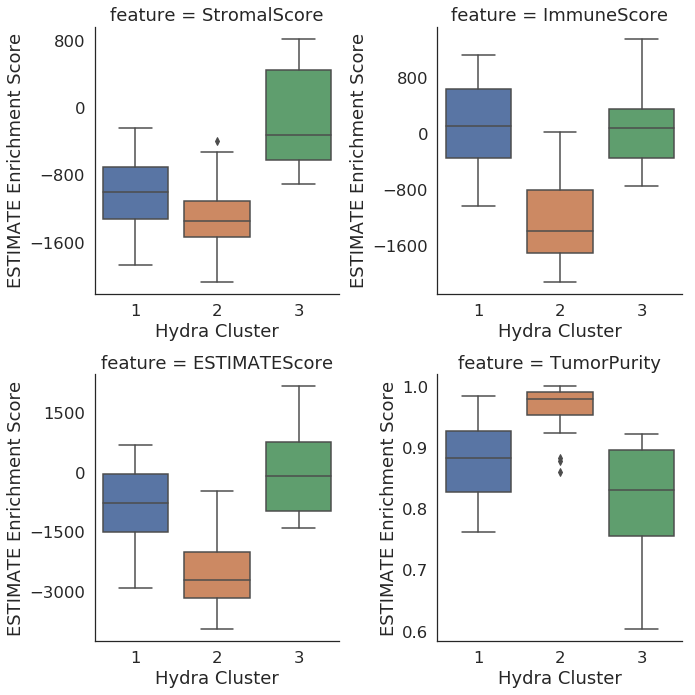

In [45]:
mask = (immune['source'] == 'Estimate') & (immune['feature'].isin(sigs['Estimate']))

t = immune[mask]

g = sns.catplot(x='cluster', 
                y='value', 
                col='feature',
                kind='box',
                col_wrap=2,
                sharex=False,
                sharey=False,
                data=t)

for i in range(len(g.axes)):
    g.axes[i].set_xlabel('Hydra Cluster')
    g.axes[i].set_ylabel('ESTIMATE Enrichment Score')
    
plt.subplots_adjust(hspace=0.3, wspace=0.4)

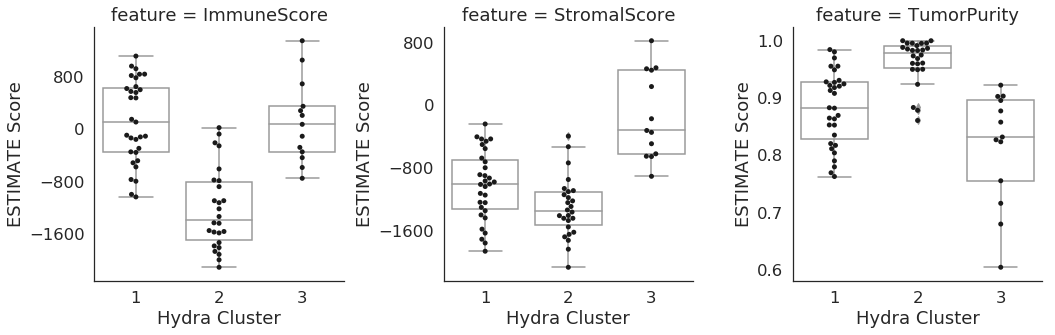

In [46]:
sns.set(font_scale=1.5, style='white')

interest = ["ImmuneScore",
            "StromalScore",
            "TumorPurity"]

mask = (immune['source'] == 'Estimate') #& (immune['feature'].isin(sigs['Estimate']))

t = immune[mask]

g = sns.catplot(x='cluster', 
                y='value', 
                col='feature',
                kind='box',
                col_wrap=3,
                col_order=interest,
                color='white',
                sharex=False,
                sharey=False,
                data=t)

# Immune Score
sns.swarmplot(x='cluster',
              y='value',
              color='k',
              size=5,
              data=t[t['feature'] == 'ImmuneScore'],
              ax=g.axes[0])

# Stromal Score
sns.swarmplot(x='cluster',
              y='value',
              color='k',
              size=5,
              data=t[t['feature'] == 'StromalScore'],
              ax=g.axes[1])

# Stromal Score
sns.swarmplot(x='cluster',
              y='value',
              color='k',
              size=5,
              data=t[t['feature'] == 'TumorPurity'],
              ax=g.axes[2])


for i in range(len(g.axes)):
    g.axes[i].set_xlabel('Hydra Cluster')
    g.axes[i].set_ylabel('ESTIMATE Score')
    
plt.subplots_adjust(hspace=0.3, wspace=0.4)

pth = '../img/ESTIMATE-Plots.svg'
plt.savefig(pth, format='svg', bbox_inches='tight')

pth = '../img/ESTIMATE-Plots.png'
plt.savefig(pth, format='png', bbox_inches='tight')

In [47]:
mask = (features['feature'] == 'ATRX') & (features['value'] == 'deleted')

atrx = features.loc[mask, 'root'].values

In [48]:
print('\n'.join(atrx))

TARGET-30-PAILNU
TARGET-30-PAKZRF
TARGET-30-PALFPI
TARGET-30-PALNLU
TARGET-30-PAMVLG
TARGET-30-PANLET
TARGET-30-PANXJL
TARGET-30-PANZVU
TARGET-30-PAPKXS
TARGET-30-PARACS
TARGET-30-PARKNP
TARGET-30-PARMLF
TARGET-30-PARYNK
TARGET-30-PASAAN
TARGET-30-PASRFS
TARGET-30-PASTCN
TARGET-30-PATGLU


In [49]:
# Check for relationship between tumor purity
# and clustering. I didn't see one the first time 
# I ran this.

m = np.zeros((2, max(assign[1])))

tperc = pd.DataFrame(columns=['sample', '%tumor', 'cluster'])
for sample in exp.columns:
    root = '-'.join(sample.split('-')[:3])
    mask = (features['root'] == root) & (features['feature'] == '%tumor')
    v = features.loc[mask, 'value'].item()
    if pd.isnull(v):
        continue
        
    c = assign.loc[sample, 1]
        
    if v > 75:
        m[1, c - 1] += 1
        
    else:
        
        m[0, c - 1] += 1
        
    if root in atrx:
        print sample, v, assign.loc[sample, 1]
        
    tperc.loc[len(tperc), :] = [sample, v, c]
        
tperc['%tumor'] = pd.to_numeric(tperc['%tumor'])

print m
        
_fisher(m)

TARGET-30-PARACS-01 80.0 1
TARGET-30-PARYNK-01 90.0 1
TARGET-30-PASRFS-01 70.0 1
TARGET-30-PASTCN-01 50.0 1
TARGET-30-PATGLU-01 80.0 1
[[ 9.  6.  1.]
 [14. 10.  7.]]


0.3889424

KruskalResult(statistic=4.1278409090909, pvalue=0.1269552706019148)


,1,2,3
1,-1.000000,0.403396,0.169075
2,0.403396,-1.000000,0.538102
3,0.169075,0.538102,-1.000000


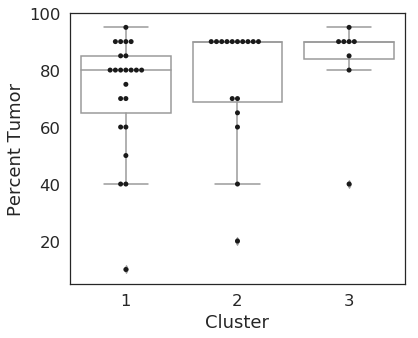

In [50]:
fig, ax = plt.subplots(1, figsize=(6, 5))

sns.boxplot(x='cluster', 
            y ='%tumor', 
            data=tperc,
            color='white',
            ax=ax)

sns.swarmplot(x='cluster', 
              y ='%tumor', 
              data=tperc,
              color='k',
              ax=ax)

tgroups = []
for c, rows in tperc.groupby('cluster'):
    tgroups.append(list(rows['%tumor'].values))
    
ax.set_xlabel('Cluster')
ax.set_ylabel('Percent Tumor')

pth = '../img/perc-tumor-dist.svg'

plt.savefig(pth,
            format='svg',
            bbox_inches='tight')

print kruskal(*tgroups)

sp.posthoc_mannwhitney(tgroups, 
                       p_adjust='holm')

In [63]:
annotations = []

atrx_a = []
atrx_samples = []

hydra_cols = []

m3c5000_cols = []
m3c500_cols = []

for sample in assign.sort_values(1).index.values:
    root = '-'.join(sample.split('-')[:3])
    cluster = assign.loc[sample, 1]
    
    if cluster == 1:
        hydra_cols.append("#3274a1")
        
    elif cluster == 2:
        hydra_cols.append("#e1812c")
        
    elif cluster == 3:
        hydra_cols.append("#3a923a")
        
    elif cluster == 4:
        hydra_cols.append("orange")
     
    if root in atrx:
        atrx_a.append('red')
        atrx_samples.append(sample)
         
    else:
        atrx_a.append('gray')

    m3c5000_c = m3c5000.loc[sample, 'consensuscluster']
    m3c500_c = m3c500.loc[sample, 'consensuscluster']
    
    if m3c5000_c == 1:
        m3c5000_cols.append('#0e4220')
        
    elif m3c5000_c == 2:
        m3c5000_cols.append('#542788')
        
    else:
        raise ValueError()
        
    if m3c500_c == 1:
        m3c500_cols.append('#7F002B')
        
    elif m3c500_c == 2:
        m3c500_cols.append('#C8C8C8')
        
    elif m3c500_c == 3:
        m3c500_cols.append('#8BC3C0')
        
    else:
        raise ValueError()
    
    
        
        
annotations.append(hydra_cols)
annotations.append(m3c5000_cols)
annotations.append(m3c500_cols)
annotations.append(atrx_a)

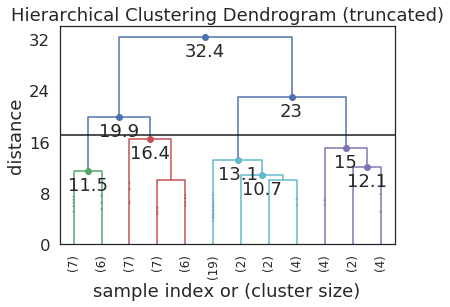

In [64]:
import collections

from scipy.spatial import distance
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import fcluster, cophenet, linkage, dendrogram
from scipy.spatial.distance import pdist;

def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata;


zscore_df = exp.reindex(genes).dropna().apply(lambda x: (x - x.mean()) / x.std(), axis=1) 

method = 'ward'
metric = 'euclidean'

row_linkage = hierarchy.linkage(
    distance.pdist(zscore_df.values), 
    method=method, metric=metric)

col_linkage = hierarchy.linkage(
    distance.pdist(zscore_df.values.T), 
    method=method, metric=metric);

dist = 17

fancy_dendrogram(
    col_linkage,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=dist,
)
plt.show()

clusters = fcluster(col_linkage, dist, criterion='distance')

cmap = sns.color_palette("Set2", max(clusters))

rcolors = [cmap[i - 1] for i in clusters]

groups = collections.defaultdict(list)
for sample, cluster in zip(zscore_df.columns, clusters):
    groups[cluster].append(sample);

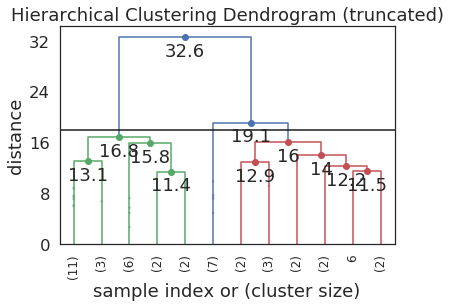

In [65]:
# Cluster rows and assign function

dist = 18

fancy_dendrogram(
    row_linkage,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=dist,
)
plt.show()

rclusters = fcluster(row_linkage, dist, criterion='distance')

rcmap = sns.color_palette("Set2", max(rclusters))

_rcolors = [rcmap[i -1] for i in rclusters]

rgroups = collections.defaultdict(list)
for sample, cluster in zip(zscore_df.index, rclusters):
    rgroups[cluster].append(sample);

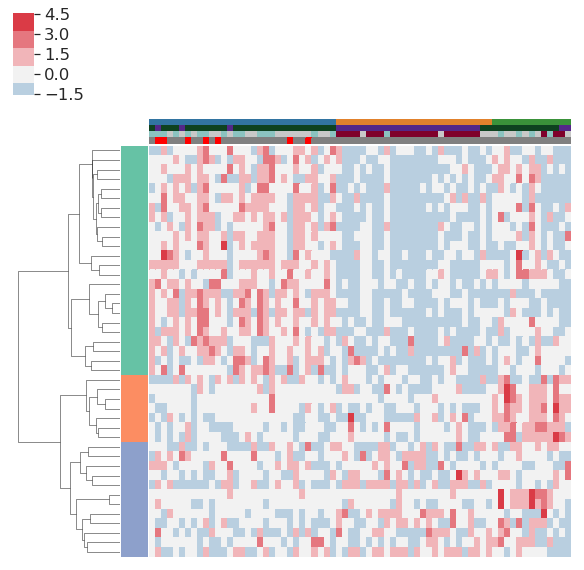

In [66]:
import seaborn as sns

col_order = assign.sort_values(1).index.values

g = sns.clustermap(exp.reindex(genes).dropna().reindex(col_order, axis=1),
                   col_cluster=False,
                   row_linkage=row_linkage,
                   col_colors=annotations,
                   row_colors=_rcolors,
                   z_score=0,
                   method='ward',
                   center=0,
                   cmap=sns.diverging_palette(240, 10, n=7),
                   figsize=(10, 10))

ax = g.ax_heatmap

ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticklabels([])
ax.set_yticks([])

pth = '../img/micro-expression-heatmap.svg'
plt.savefig(pth, format='svg', bbox_inches='tight')

pth = '../img/micro-expression-heatmap.png'
plt.savefig(pth, format='png', bbox_inches='tight')

CD274
          1         2         3
1 -1.000000  0.000386  0.907839
2  0.000386 -1.000000  0.019275
3  0.907839  0.019275 -1.000000
CTLA4
              1             2         3
1 -1.000000e+00  2.124570e-09  0.777185
2  2.124570e-09 -1.000000e+00  0.000057
3  7.771848e-01  5.691264e-05 -1.000000


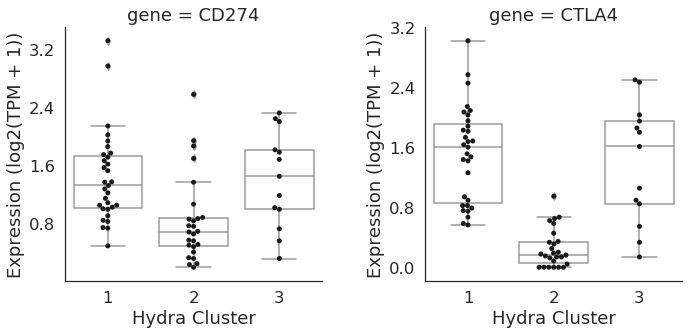

In [67]:
import scikit_posthocs as sp
from scipy.stats import mannwhitneyu

checkpoint = pd.DataFrame(columns=['sample',
                                   'cluster', 
                                   'gene', 
                                   'value'])

for sample in exp.columns:
    cluster = assign.loc[sample, 1]
    for gene in ['CD274', 'CTLA4']:
        checkpoint.loc[len(checkpoint), :] = [sample,
                                              cluster, 
                                              gene, 
                                              exp.loc[gene, sample]]
        
checkpoint['value'] = pd.to_numeric(checkpoint['value'])

sns.set(font_scale=1.5, style='white')

g = sns.catplot(x='cluster', 
                y='value', 
                col='gene',
                kind='box',
                col_wrap=2,
                color='white',
                sharex=False,
                sharey=False,
                data=checkpoint)

sns.swarmplot(x='cluster',
              y='value',
              color='k',
              size=5,
              data=checkpoint[checkpoint['gene'] == 'CD274'],
              ax=g.axes[0])

# CD8+ T-cells
sns.swarmplot(x='cluster',
              y='value',
              color='k',
              size=5,
              data=checkpoint[checkpoint['gene'] == 'CTLA4'],
              ax=g.axes[1])

for i in range(len(g.axes)):
    g.axes[i].set_xlabel('Hydra Cluster')
    g.axes[i].set_ylabel('Expression (log2(TPM + 1))')
    
plt.subplots_adjust(hspace=0.3, wspace=0.4)

pth = '../img/Checkpoint-Plots-V1.svg'
plt.savefig(pth, format='svg', bbox_inches='tight')

for gene in ['CD274', 'CTLA4']:
    print gene
    print sp.posthoc_mannwhitney(checkpoint[checkpoint['gene'] == gene],
                           val_col='value',
                           group_col='cluster',
                           p_adjust='fdr_bh')

Missing:  TARGET-30-PALNVP-01
Missing:  TARGET-30-PALUYS-01
Missing:  TARGET-30-PALXTB-01
Missing:  TARGET-30-PANBJH-01
Missing:  TARGET-30-PAPEAV-01
Missing:  TARGET-30-PAPUAR-01
Missing:  TARGET-30-PAPUEB-01
Missing:  TARGET-30-PARHAM-01
Missing:  TARGET-30-PARHAM-02
Missing:  TARGET-30-PATNKP-02
Missing:  TARGET-30-PATYIL-01
Missing:  TARGET-30-PATYIL-02


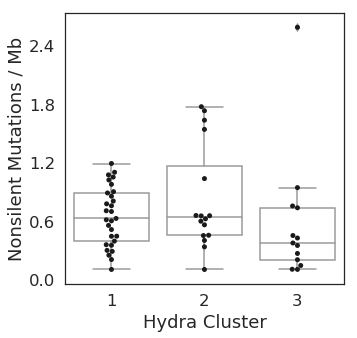

In [68]:
pth = '../data/meta/ng.2529-S2.xlsx'

pugh = pd.read_excel(pth, index_col=0, header=1)

burden = pd.DataFrame(columns=['sample', 'burden', 'cluster'])

for sample in exp.columns:
    
    cluster = assign.loc[sample, 1]
    root = '-'.join(sample.split('-')[:3])
    
    try:
        bd = pugh.loc[root, 'Nonsilent per Mb']
        
    except KeyError:
        print 'Missing: ', sample
        continue
        
    burden.loc[len(burden), :] = [sample, bd, cluster]
    
burden['burden'] = pd.to_numeric(burden['burden'])

fig, ax = plt.subplots(1, 
                       figsize=(5, 5))

g = sns.boxplot(x='cluster',
                y='burden',
                data=burden,
                color='white',
                ax=ax)


sns.swarmplot(x='cluster',
              y='burden',
              data=burden,
              color='k',
              size=5,
              ax=ax)

g.set_xlabel('Hydra Cluster')
g.set_ylabel('Nonsilent Mutations / Mb')

pth = '../img/mutation-burden.svg'
plt.savefig(pth, format='svg', bbox_inches='tight')

In [69]:
assign

,1
TARGET-30-PAITCI-01,3
TARGET-30-PAITEG-01,3
TARGET-30-PAIVHE-01,3
TARGET-30-PALBFW-01,3
TARGET-30-PALCBW-01,3
TARGET-30-PALETP-01,1
TARGET-30-PALIIN-01,1
TARGET-30-PALNVP-01,2
TARGET-30-PALTEG-01,1
TARGET-30-PALUYS-01,2


In [70]:
!ls ../data/cluster-analysis/

MYCN-NA-GAP-MAD-1000-labels-2.tsv
MYCN-NA-GAP-MAD-100-labels-6.tsv
MYCN-NA-GAP-MAD-2500-labels-2.tsv
MYCN-NA-GAP-MAD-5000-labels-1.tsv
MYCN-NA-GAP-MAD-500-labels-2.tsv
MYCN-NA-M3C-MAD-1000-labels-2.tsv
MYCN-NA-M3C-MAD-1000.tsv
MYCN-NA-M3C-MAD-100-labels-5.tsv
MYCN-NA-M3C-MAD-100.tsv
MYCN-NA-M3C-MAD-2500-labels-2.tsv
MYCN-NA-M3C-MAD-2500.tsv
MYCN-NA-M3C-MAD-5000-labels-2.tsv
MYCN-NA-M3C-MAD-5000.tsv
MYCN-NA-M3C-MAD-500-labels-3.tsv
MYCN-NA-M3C-MAD-500.tsv
MYCN-NA-M3C.tsv
NO-MM-MYCN-NA-GAP-MAD-1000-labels-2.tsv
NO-MM-MYCN-NA-GAP-MAD-100-labels-3.tsv
NO-MM-MYCN-NA-GAP-MAD-100-labels-6.tsv
NO-MM-MYCN-NA-GAP-MAD-2500-labels-2.tsv
NO-MM-MYCN-NA-GAP-MAD-5000-labels-1.tsv
NO-MM-MYCN-NA-GAP-MAD-500-labels-2.tsv
NO-MM-MYCN-NA-M3C-MAD-1000-labels-2.tsv
NO-MM-MYCN-NA-M3C-MAD-1000.tsv
NO-MM-MYCN-NA-M3C-MAD-100-labels-5.tsv
NO-MM-MYCN-NA-M3C-MAD-100-labels-8.tsv
NO-MM-MYCN-NA-M3C-MAD-100.tsv
NO-MM-MYCN-NA-M3C-MAD-2500-labels-2.tsv
NO-MM-MYCN-NA-M3C-MAD-2500.tsv
NO-MM-MYCN-NA-M3C-MAD-5000-labels-2.ts

In [71]:
import glob 
from sklearn.metrics import adjusted_rand_score

# Clustering Analysis

_dir = '../data/cluster-analysis/'

cluster_screen = pd.DataFrame(columns=['Method', 'Threshold', 'Clusters', 'Rand Index'])
for pth in glob.glob(os.path.join(_dir, 'MYCN-NA-*labels*')):
    print(pth)
    if "MYCN-NA-M3C.tsv" in pth:
        continue
        
    b = os.path.basename(pth)
    fields = b.split('-')
    
    method = fields[2] if fields[2] == 'M3C' else 'Gap Statistic\nKmeans'
    threshold = fields[4]
    clusters = fields[-1].replace('.tsv', '')
    
    
    labels = pd.read_csv(pth, sep='\t')
    samples = [x.replace('.', '-') for x in labels.index.values]
    labels.index = samples
    
    if method == 'M3C':
        clustering = labels.reindex(assign.index)['consensuscluster'].values
            
    else:
        clustering = labels.reindex(assign.index)['x'].values
    
    hydra_clusters = assign[1].values
    ri = adjusted_rand_score(clustering, hydra_clusters)
    
    cluster_screen.loc[len(cluster_screen), :] = [method, threshold, clusters, ri]
    
cluster_screen['Threshold'] = pd.to_numeric(cluster_screen['Threshold'])
cluster_screen['Clusters'] = pd.to_numeric(cluster_screen['Clusters'])
cluster_screen['Rand Index'] = pd.to_numeric(cluster_screen['Rand Index'])

../data/cluster-analysis/MYCN-NA-M3C-MAD-5000-labels-2.tsv
../data/cluster-analysis/MYCN-NA-GAP-MAD-500-labels-2.tsv
../data/cluster-analysis/MYCN-NA-M3C-MAD-500-labels-3.tsv
../data/cluster-analysis/MYCN-NA-GAP-MAD-5000-labels-1.tsv
../data/cluster-analysis/MYCN-NA-M3C-MAD-100-labels-5.tsv
../data/cluster-analysis/MYCN-NA-GAP-MAD-1000-labels-2.tsv
../data/cluster-analysis/MYCN-NA-GAP-MAD-100-labels-6.tsv
../data/cluster-analysis/MYCN-NA-M3C-MAD-2500-labels-2.tsv
../data/cluster-analysis/MYCN-NA-GAP-MAD-2500-labels-2.tsv
../data/cluster-analysis/MYCN-NA-M3C-MAD-1000-labels-2.tsv


In [72]:
cluster_screen

,Method,Threshold,Clusters,Rand Index
0,M3C,5000,2,0.450813
1,Gap Statistic\nKmeans,500,2,0.511705
2,M3C,500,3,0.331436
3,Gap Statistic\nKmeans,5000,1,0.000000
4,M3C,100,5,0.304036
5,Gap Statistic\nKmeans,1000,2,0.473016
6,Gap Statistic\nKmeans,100,6,0.233369
7,M3C,2500,2,0.480499
8,Gap Statistic\nKmeans,2500,2,0.516781
9,M3C,1000,2,0.395736


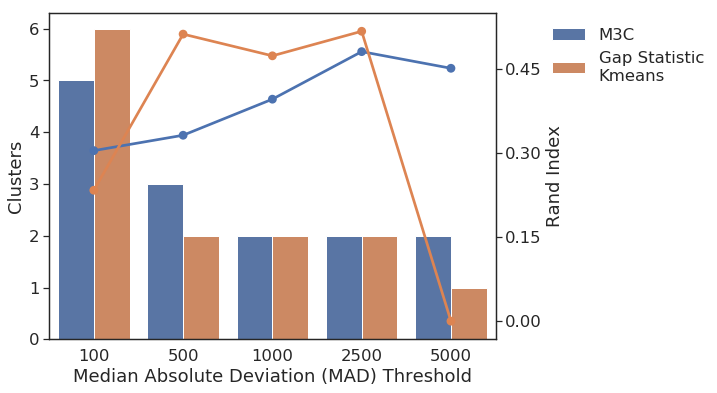

In [73]:
fig, ax = plt.subplots(1, figsize=(8, 6))

sns.barplot(x='Threshold', 
            y='Clusters', 
            hue='Method',
            data=cluster_screen, ax=ax)

ax.set_yticks(range(7))
ax.set_yticklabels(range(7))
ax.set_xlabel("Median Absolute Deviation (MAD) Threshold")

ax.legend(bbox_to_anchor=(1.5, 1.0), frameon=False)

ax2 = ax.twinx()
sns.pointplot(x='Threshold', 
            y='Rand Index', 
            hue='Method', 
            data=cluster_screen,
            ax=ax2)

ax2.get_legend().remove()

plt.savefig('../img/clustering-screen.svg', 
            format='svg', 
            bbox_inches='tight')

In [74]:
help(clus.sub_cluster_gsea)

Help on method sub_cluster_gsea in module library.analysis:

sub_cluster_gsea(self, data, constant=0.05, gmt=None, return_diff=False, alpha=0.05, debug=False) method of library.analysis.MultivariateMixtureModel instance
    Performs N-of-1 GSEA by normalizing the sample to the cluster background. (BETA)
    
    :param data (pd.Series): Expression Series for N-of-1 sample
    :param constant (float): PAM normalizing factor for ranking genes
    :param gmt (str): Path to gene set file in GMT format
    :param return_diff (bool): Removes enriched gene sets that could have been identified at the cohort level
    :param alpha (float): P-value threshold for assessing statistical significance.
    :return:



In [75]:
diff_gsea = {}
for sample in exp.columns:
    a, ret = clus.sub_cluster_gsea(exp[sample],
                                   return_diff=True,
                                   gmt='/opt/hydra/gene-sets/Human_GOBP_AllPathways_no_GO_iea_December_01_2018_symbol.gmt')
    
    diff_gsea[sample] = ret
    
    if len(ret[(ret['padj'] < 0.05) & (ret['ES'] > 0)]):
        print(sample, a)
        print(ret.index.values)
        print('\n\n')

('TARGET-30-PALUYS-01', 1)
['HEPATIC IMMUNE RESPONSE%GOBP%GO:0002384'
 'BIOCARTA_IL10_PATHWAY%MSIGDB_C2%BIOCARTA_IL10_PATHWAY'
 'T-HELPER CELL DIFFERENTIATION%GOBP%GO:0042093'
 'CELLULAR RESPONSE TO DRUG%GOBP%GO:0035690'
 'IL27-MEDIATED SIGNALING EVENTS%PATHWAY INTERACTION DATABASE NCI-NATURE CURATED DATA%IL27-MEDIATED SIGNALING EVENTS'
 'CELLULAR RESPONSES TO STRESS%REACTOME DATABASE ID RELEASE 66%2262752'
 'REGULATION OF LIPID STORAGE%GOBP%GO:0010883'
 'CYTOKINES AND INFLAMMATORY RESPONSE%WIKIPATHWAYS_20181110%WP530%HOMO SAPIENS'
 'NEURON PROJECTION DEVELOPMENT%GOBP%GO:0031175'
 'BIOCARTA_IL5_PATHWAY%MSIGDB_C2%BIOCARTA_IL5_PATHWAY'
 'NEGATIVE REGULATION OF CELL DEVELOPMENT%GOBP%GO:0010721'
 'EXTRACELLULAR VESICLES IN THE CROSSTALK OF CARDIAC CELLS%WIKIPATHWAYS_20181110%WP4300%HOMO SAPIENS'
 'SHP2 SIGNALING%PATHWAY INTERACTION DATABASE NCI-NATURE CURATED DATA%SHP2 SIGNALING'
 'CELLULAR RESPONSE TO OXIDATIVE STRESS%GOBP%GO:0034599'
 'REGULATION OF BONE REMODELING%GOBP%GO:0046850'
 'REG

('TARGET-30-PANNMS-01', 0)
['INSEMINATION%GOBP%GO:0007320' 'COPULATION%GOBP%GO:0007620'
 'SEXUAL REPRODUCTION%GOBP%GO:0019953' 'MATING%GOBP%GO:0007618'
 'DETECTION OF STIMULUS%GOBP%GO:0051606'
 'DETECTION OF ABIOTIC STIMULUS%GOBP%GO:0009582'
 'TACHYKININ RECEPTOR SIGNALING PATHWAY%GOBP%GO:0007217'
 'TACHYKININ RECEPTORS BIND TACHYKININS%REACTOME%R-HSA-380095.2']



('TARGET-30-PANRVJ-01', 2)
['POSITIVE REGULATION OF MACROMOLECULE METABOLIC PROCESS%GOBP%GO:0010604'
 'REGULATION OF CELLULAR METABOLIC PROCESS%GOBP%GO:0031323'
 'POSITIVE REGULATION OF CELL DIFFERENTIATION%GOBP%GO:0045597'
 'POSITIVE REGULATION OF DEVELOPMENTAL PROCESS%GOBP%GO:0051094'
 'POSITIVE REGULATION OF METABOLIC PROCESS%GOBP%GO:0009893'
 'POSITIVE REGULATION OF CELLULAR METABOLIC PROCESS%GOBP%GO:0031325'
 'REGULATION OF DEVELOPMENTAL PROCESS%GOBP%GO:0050793'
 'DEVELOPMENTAL PROCESS%GOBP%GO:0032502'
 'REGULATION OF CELL DIFFERENTIATION%GOBP%GO:0045595'
 'POSITIVE REGULATION OF NITROGEN COMPOUND METABOLIC PROCESS%GOBP

In [77]:
count = 0
for k, v in diff_gsea.items():
    if len(v) > 0:
        count += 1
count

6